In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Random Features and Kernels

## Random linear features: Johnson-Lindenstrauss lemma

Briefly speaking, the JL lemma guarantees that some maps preserve distance in an approximate way. More precisely

> Given $0 < \varepsilon < 1$, a set $X$ of $m$ points in $\mathbb{R}^N$, and a number $n > 8 \log(m) / \varepsilon^2$, there is a linear map $f: \mathbb{R}^N \to \mathbb{R}^n$ such that
>
>$$(1 - \varepsilon) \|u - v\|^2 \leq \|f(u) - f(v)\|^2 \leq (1 + \varepsilon) \|u - v\|^2$$
>
> for all $u, v \in X$.

Moreover, we actually know how to construct such maps; for instance, we know that 

$$f(x) = \frac{1}{\sqrt{n}} A x, \qquad A_{ij} \sim \mathcal{N} (0, 1)$$

proves the lemma. Let us see how this works in practice! We first load some dataset, say the Boston dataset of house prices.

In [2]:
from sklearn import datasets
dset = datasets.load_boston()
print(dset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

This is a fairly small dataset, it should allows us to run things fast. Let's split the dataset in training/test sets, and do some preprocessing.

In [3]:
X, y = dset.data, dset.target
print("number of samples/features: %d, %d" % X.shape)

# Do train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print("samples/features in training set: %d, %d" % X_train.shape)

# Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

number of samples/features: 506, 13
samples/features in training set: 455, 13


Let's try the map mentioned above. We gonna generate $K$ new features by performing linear combinations of the features at random, with coefficients sampled from a standard Normal distribution. Our new set of samples is then gonna contain $N$ samples, each of dimension $K$ (instead of $P$).

In [4]:
def generate_random_features(X, n_projections):
    n_features = X.shape[1]
    W = np.random.randn(n_features, n_projections) / np.sqrt(n_projections)
    return X.dot(W)

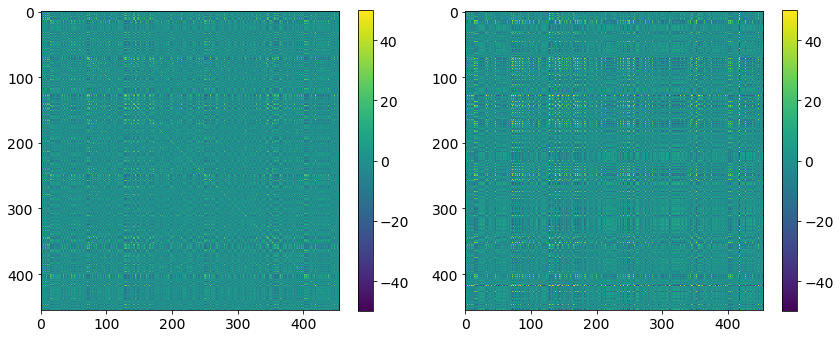

In [5]:
# Generate new set of samples by mapping from 30 features to 2
X_transf = generate_random_features(X_train, 2)

# Plot Gram matrix ...
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# ... for the original set of samples ...
p0 = axs[0].imshow(X_train.dot(X_train.T), interpolation="nearest", vmin = -50, vmax = 50)
plt.colorbar(p0, ax=axs[0], shrink = 0.75)

# ... and for the transformed one.
p1 = axs[1].imshow(X_transf.dot(X_transf.T), interpolation="nearest", vmin = -50, vmax = 50)
plt.colorbar(p1, ax=axs[1], shrink = 0.75)
plt.tight_layout()

By playing a bit with the number of features in the transformed space, we can see how the Gramiam evolves.

Next we want to see how the distance between points change as we change the number of features in the transformed space.

**Exercise**: plot 2D histogram of distances between samples in original and transformed space. Tip: take a look at the `hist2d` function in Matplotlib.

In [6]:
from scipy.spatial.distance import pdist

# Compute distance matrix for both original and transformed sets of features
dists_orig =
dists_proj =

# Plot 2D histogram of distances between samples in original/transformed spaces

SyntaxError: invalid syntax (<ipython-input-6-5aaff599533f>, line 4)

(array([[  3.,   6.,   0., ...,   0.,   0.,   0.],
        [  3.,   7.,   8., ...,   0.,   0.,   0.],
        [  4.,  14.,  11., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.11180902,   0.24677717,   0.38174533,   0.51671349,
          0.65168165,   0.78664981,   0.92161797,   1.05658613,
          1.19155429,   1.32652245,   1.4614906 ,   1.59645876,
          1.73142692,   1.86639508,   2.00136324,   2.1363314 ,
          2.27129956,   2.40626772,   2.54123587,   2.67620403,
          2.81117219,   2.94614035,   3.08110851,   3.21607667,
          3.35104483,   3.48601299,   3.62098115,   3.7559493 ,
          3.89091746,   4.02588562,   4.16085378,   4.29582194,
          4.4307901 ,   4.56575826,   4.70072642,   4.83569457,
          4.97066273,   5.10563089,   5.24059905,   5.37556721,
          5.51053537,   5.64550353,   

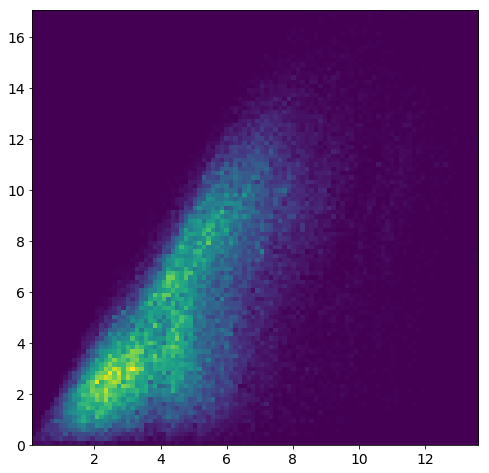

In [8]:
# Uncomment the line below to see the solution to the exericse
#%load rks1.py

## Random non-linear features

We now replace $\langle{\bf x}_i, {\bf x}_j\rangle$ by a kernel function $K({\bf x}_i, {\bf x}_j)$, more specifically by the RBF kernel $K({\bf x}_i, {\bf x}_j) = e^{-\frac{1}{2} \| {\bf x}_i - {\bf x}_j \|^2_2}$. This essentially take us to infinite dimension!

**Exercise**: compute and plot the kernelized Gram matrix for our dataset.

In [ ]:
# Compute Gram matrix using the original kernel ...
from scipy.spatial.distance import cdist
gram_orig =

# ... and plot it.
plt.imshow(gram_orig, interpolation="nearest")

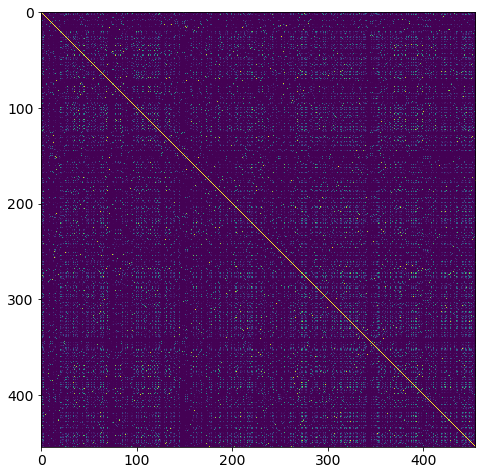

In [10]:
# Uncomment the line below to see the solution
#%load rks2.py

As we saw, it's often more efficient to *approximate* the kernel by expanding it in a given basis (usually Fourier) and then approximately performing the integral via importance sampling. This provides us with a map 

$$\phi({\bf x}_i, {\bf w}) = e^{i {\bf w} \cdot {\bf x}_i}$$

such that 

$$K({\bf x}_i, {\bf x}_j) \approx \sum_{{\bf w} \sim \mathcal{N} (0, I_P)} \phi({\bf x}_i, {\bf w}) \phi({\bf x}_j, {\bf w})$$

This is the so-called *random kitchen sinks* algorithm. Let's implement it!

![RKS](rks.png)

In [ ]:
def generate_nonlinear_features(X, n_projections):
    n_features = X.shape[1]
    
    # Sample w
    w =
    
    # Compute z
    z =
    return z

In [13]:
# Uncomment the line below to see the solution to the exercise
#%load rks3.py

We can see how the approximated Gram matrix approaches the exact one as `n_projections` increase.

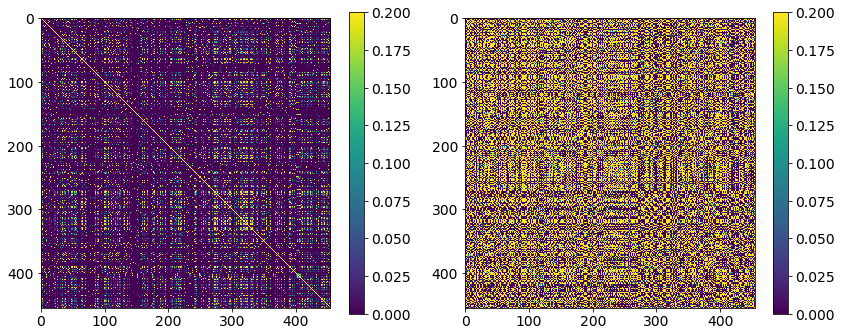

In [17]:
# Compute the Gram matrix using the approximate kernel
X_transf = generate_nonlinear_features(X_train, 2)
gram_approx = X_transf.dot(X_transf.T)

# Plot Gram matrices using both exact and approximate kernels
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
p0 = axs[0].imshow(gram_orig, interpolation="nearest", vmin = 0, vmax = 0.2)
p1 = axs[1].imshow(gram_approx, interpolation="nearest", vmin = 0, vmax = 0.2)
plt.colorbar(p0, ax=axs[0], shrink = 0.75)
plt.colorbar(p1, ax=axs[1], shrink = 0.75)
plt.tight_layout()

How many projections do we need before $\phi (x) \phi(\mu)$ gives a good approximation to $K(x, \mu) = e^{-\frac{(x - \mu)^2}{2}}$?

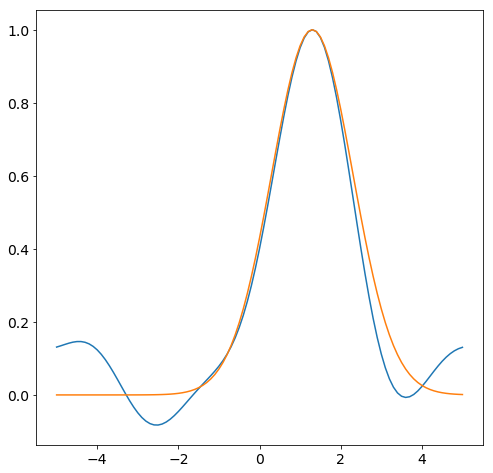

In [20]:
mu = 1.3

# Generate 1D grid
xx = np.linspace(-5, 5, 101)

# Compute kernel approximation
def compute_approx(grid, n_projections):
    phi = generate_nonlinear_features((grid - mu).reshape(-1, 1), n_projections)
    return np.sum(phi, 1) / np.sqrt(n_projections)

# Plot approximation and exact kernels
plt.plot(xx, compute_approx(xx, 2))
plt.plot(xx, np.exp(-.5 * (xx - mu) ** 2))

## Kernel ridge regression

Let's see how our kernel approximation perform in the solution of linear models. We first start with doing ridge regression while replacing the Gram matrix by the (exact) kernel.

In [ ]:
def train_kernel_ridge(X, y, lamb = 0.05):
    n_samples, n_features = X.shape
    
    # Obtain kernelized Gram matrix and perform least-squares estimation
    corr =
    coef =
    
    # Compute training error
    error = np.mean((y - corr.T.dot(coef)))
    print("error on training set: %g" % error)
    
    return coef

def test_kernel_ridge(X_test, y_test, X_train, coef):
    corr =
    
    # Compute test (generalization) error
    error = np.mean((y_test - corr.T.dot(coef)) ** 2)
    print("error on test set: %g" % error)
    
    return error

coef = train_kernel_ridge(X_train, y_train)
kernel_ridge_error = test_kernel_ridge(X_test, y_test, X_train, coef)

In [23]:
# Uncomment the line below to see the solution to the exercise
#%load rks4.py

error on training set: 0.229362
error on test set: 43.418


Now let's replace the exact kernel with the approximate one. We first rewrite the `generate_nonlinear_features` function so as to receive/return $\omega$ values; this is necessary in order to compute $K$ for new points outside the training set.

In [28]:
def generate_nonlinear_features(X, n_projections, w = None):
    n_features = X.shape[1]
    if w is None:
        w = np.random.randn(n_features, n_projections)
    z = np.hstack((np.cos(X.dot(w)), np.sin(X.dot(w)))) / np.sqrt(n_projections)
    return z, w

We are now ready to rewrite the functions above using approximate kernels.

In [31]:
def train_rks(X, y, n_projections, lamb = 0.05):
    n_samples, n_features = X.shape
    
    # Obtain random features and perform least-squares estimation
    z, w = generate_nonlinear_features(X, n_projections)
    coef = z.T.dot(np.linalg.lstsq(z.dot(z.T) + lamb * np.eye(n_samples), y)[0])
    
    # Compute training error
    error = np.mean((y - z.dot(coef)))
    print("error on training set: %g" % error)
    
    return coef, w

def test_rks(X, y, coef, w):
    z, _ = generate_nonlinear_features(X, w.shape[1], w)
    
    # Compute test (generalization) error
    error = np.mean((y_test - z.dot(coef)) ** 2)
    print("error on test set: %g" % error)
    
    return error

coef, w = train_rks(X_train, y_train, 500)
test_rks(X_test, y_test, coef, w)

error on training set: 0.308669
error on test set: 47.0548


47.054848350814147

What is the performance as a function of `n_projections`?


n_projections = 200
error on training set: 0.740835
error on test set: 75.057

n_projections = 400
error on training set: 0.369256
error on test set: 40.03

n_projections = 600
error on training set: 0.32155
error on test set: 55.0678

n_projections = 800
error on training set: 0.301703
error on test set: 52.8085

n_projections = 1000
error on training set: 0.272692
error on test set: 51.8848

n_projections = 1200
error on training set: 0.268259
error on test set: 52.5196

n_projections = 1400
error on training set: 0.256989
error on test set: 47.92

n_projections = 1600
error on training set: 0.244262
error on test set: 44.714

n_projections = 1800
error on training set: 0.258863
error on test set: 52.0438

n_projections = 2000
error on training set: 0.266124
error on test set: 57.6667

n_projections = 2200
error on training set: 0.250411
error on test set: 48.2468

n_projections = 2400
error on training set: 0.261136
error on test set: 56.7907

n_projections = 2600
error on training

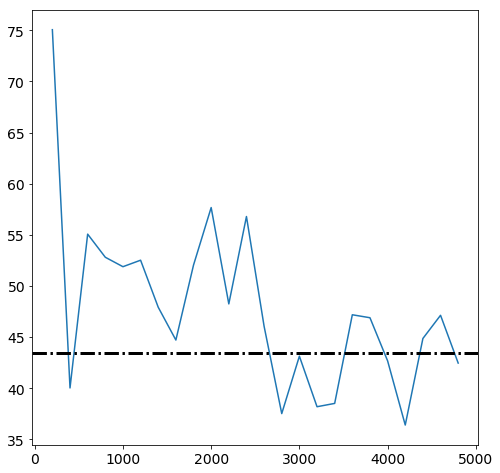

In [32]:
# Compute test error for many values of n_projections
ks = np.arange(200, 5000, 200)
errors = np.zeros(len(ks))
for (i, k) in enumerate(ks):
    print("\nn_projections = %d" % (k))
    coef, w = train_rks(X_train, y_train, k)
    errors[i] = test_rks(X_test, y_test, coef, w)

# Plot results
plt.plot(ks, errors)
plt.axhline(kernel_ridge_error, c="k", ls="-.", lw=3)

## Kernel SVM

We didn't gain so much in using RKS in the previous section, because the number of samples we had was very small. Let us try it again with a bigger dataset.

Moreover, we will use Support Vector Machines, which requires us to evaluate the kernel multiple times and not only once as in ridge regression. That makes even more important to optimize the computation.

We start by loading the MNIST dataset.

In [33]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
X, y = mnist.data, mnist.target

# Preprocess
X = X / 255.

mask = np.logical_or.reduce([(y == k) for k in [0, 1]])
X, y = X[mask, :], y[mask]

n_samples = 5000
samples = np.random.choice(X.shape[0], n_samples, replace=False)
X, y = X[samples, :], y[samples]

# Do train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("samples/features in training set: %d, %d" % X_train.shape)

samples/features in training set: 4000, 784


Then we run the kernel SVM function from scikit-learn.

In [34]:
from time import time
from sklearn import svm

# Create kernel SVM
kernel_svm = svm.SVC(gamma=.2)

# Fit kernel SVM
kernel_svm_time = time()
kernel_svm.fit(X_train, y_train)
kernel_svm_error = np.mean(y_test != kernel_svm.predict(X_test))
kernel_svm_time = time() - kernel_svm_time

Finally, we repeat the process for the Fourier-approximated kernel SVM.

In [ ]:
from sklearn import pipeline
from sklearn.kernel_approximation import RBFSampler

# Create Fourier-approximated SVM
map_fourier = RBFSampler(gamma=.2)
fourier_svm = pipeline.Pipeline([("feature_map", map_fourier),
                                 ("svm", svm.LinearSVC())])

# Fit Fourier-approximated SVM
fourier_times = []
fourier_errors = []

sample_sizes = [100, 200, 500, 1000, 2000, 5000]
for k in sample_sizes:
    fourier_svm.set_params(feature_map__n_components=k)
    
    start = time()
    fourier_svm.fit(X_train, y_train)
    fourier_times.append(time() - start)
    fourier_error = np.mean(y_test != fourier_svm.predict(X_test))
    fourier_errors.append(fourier_error)

Let us plot the results.

In [ ]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(sample_sizes, fourier_errors)
axs[0].axhline(kernel_svm_error, c="k", ls="-.", lw=2)
axs[0].set_ylabel("error")
axs[1].plot(sample_sizes, fourier_times)
axs[1].axhline(kernel_svm_time, c="k", ls="-.", lw=2)
axs[1].set_ylabel("runtime")